In [4]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

is_outlier = sod_core_dataset.is_outlier

maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/cv.allset_train.iforest.yaml/evalreports/'))
assert os.path.isdir(maindir)


# create evaluations all:
import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)

print('Creating evaluations all (html)')
sod_core_eval.aggeval(maindir, format='html')

print('Creating evaluations all (hdf)')
sod_core_eval.aggeval(maindir, format='hdf')

path = os.path.join(maindir, 'evaluations.all.hdf')


dfr = pd.read_hdf(path)
print('evaulation dataframe.\n\nColumns:\n' + str(dfr.columns.tolist()))
print('\nclassname distinct values:\n' + str(np.unique(dfr['classname'])))

Creating evaluations all (html)
Creating evaluations all (hdf)
evaulation dataframe.

Columns:
['% rec.', 'Mean log_loss', 'behaviour', 'classname', 'clf', 'contamination', 'features', 'max_samples', 'n_estimators']

classname distinct values:
['ok' 'outl. (wrong inv)' 'unlabeled (Me suspicious outl.)'
 'unlabeled (Me unknown)']


In [5]:
# Some tries to embed the html page, NOT WORKING

# from IPython.display import IFrame
# IFrame(src='file://' + os.path.join(maindir, 'evaluations.all.html'), width=700, height=600)

# from IPython.display import Javascript
# %%javascript
# from IPython.core.display import display, HTML
# display(HTML(open(os.path.join(maindir, 'evaluations.all.html')).read()))


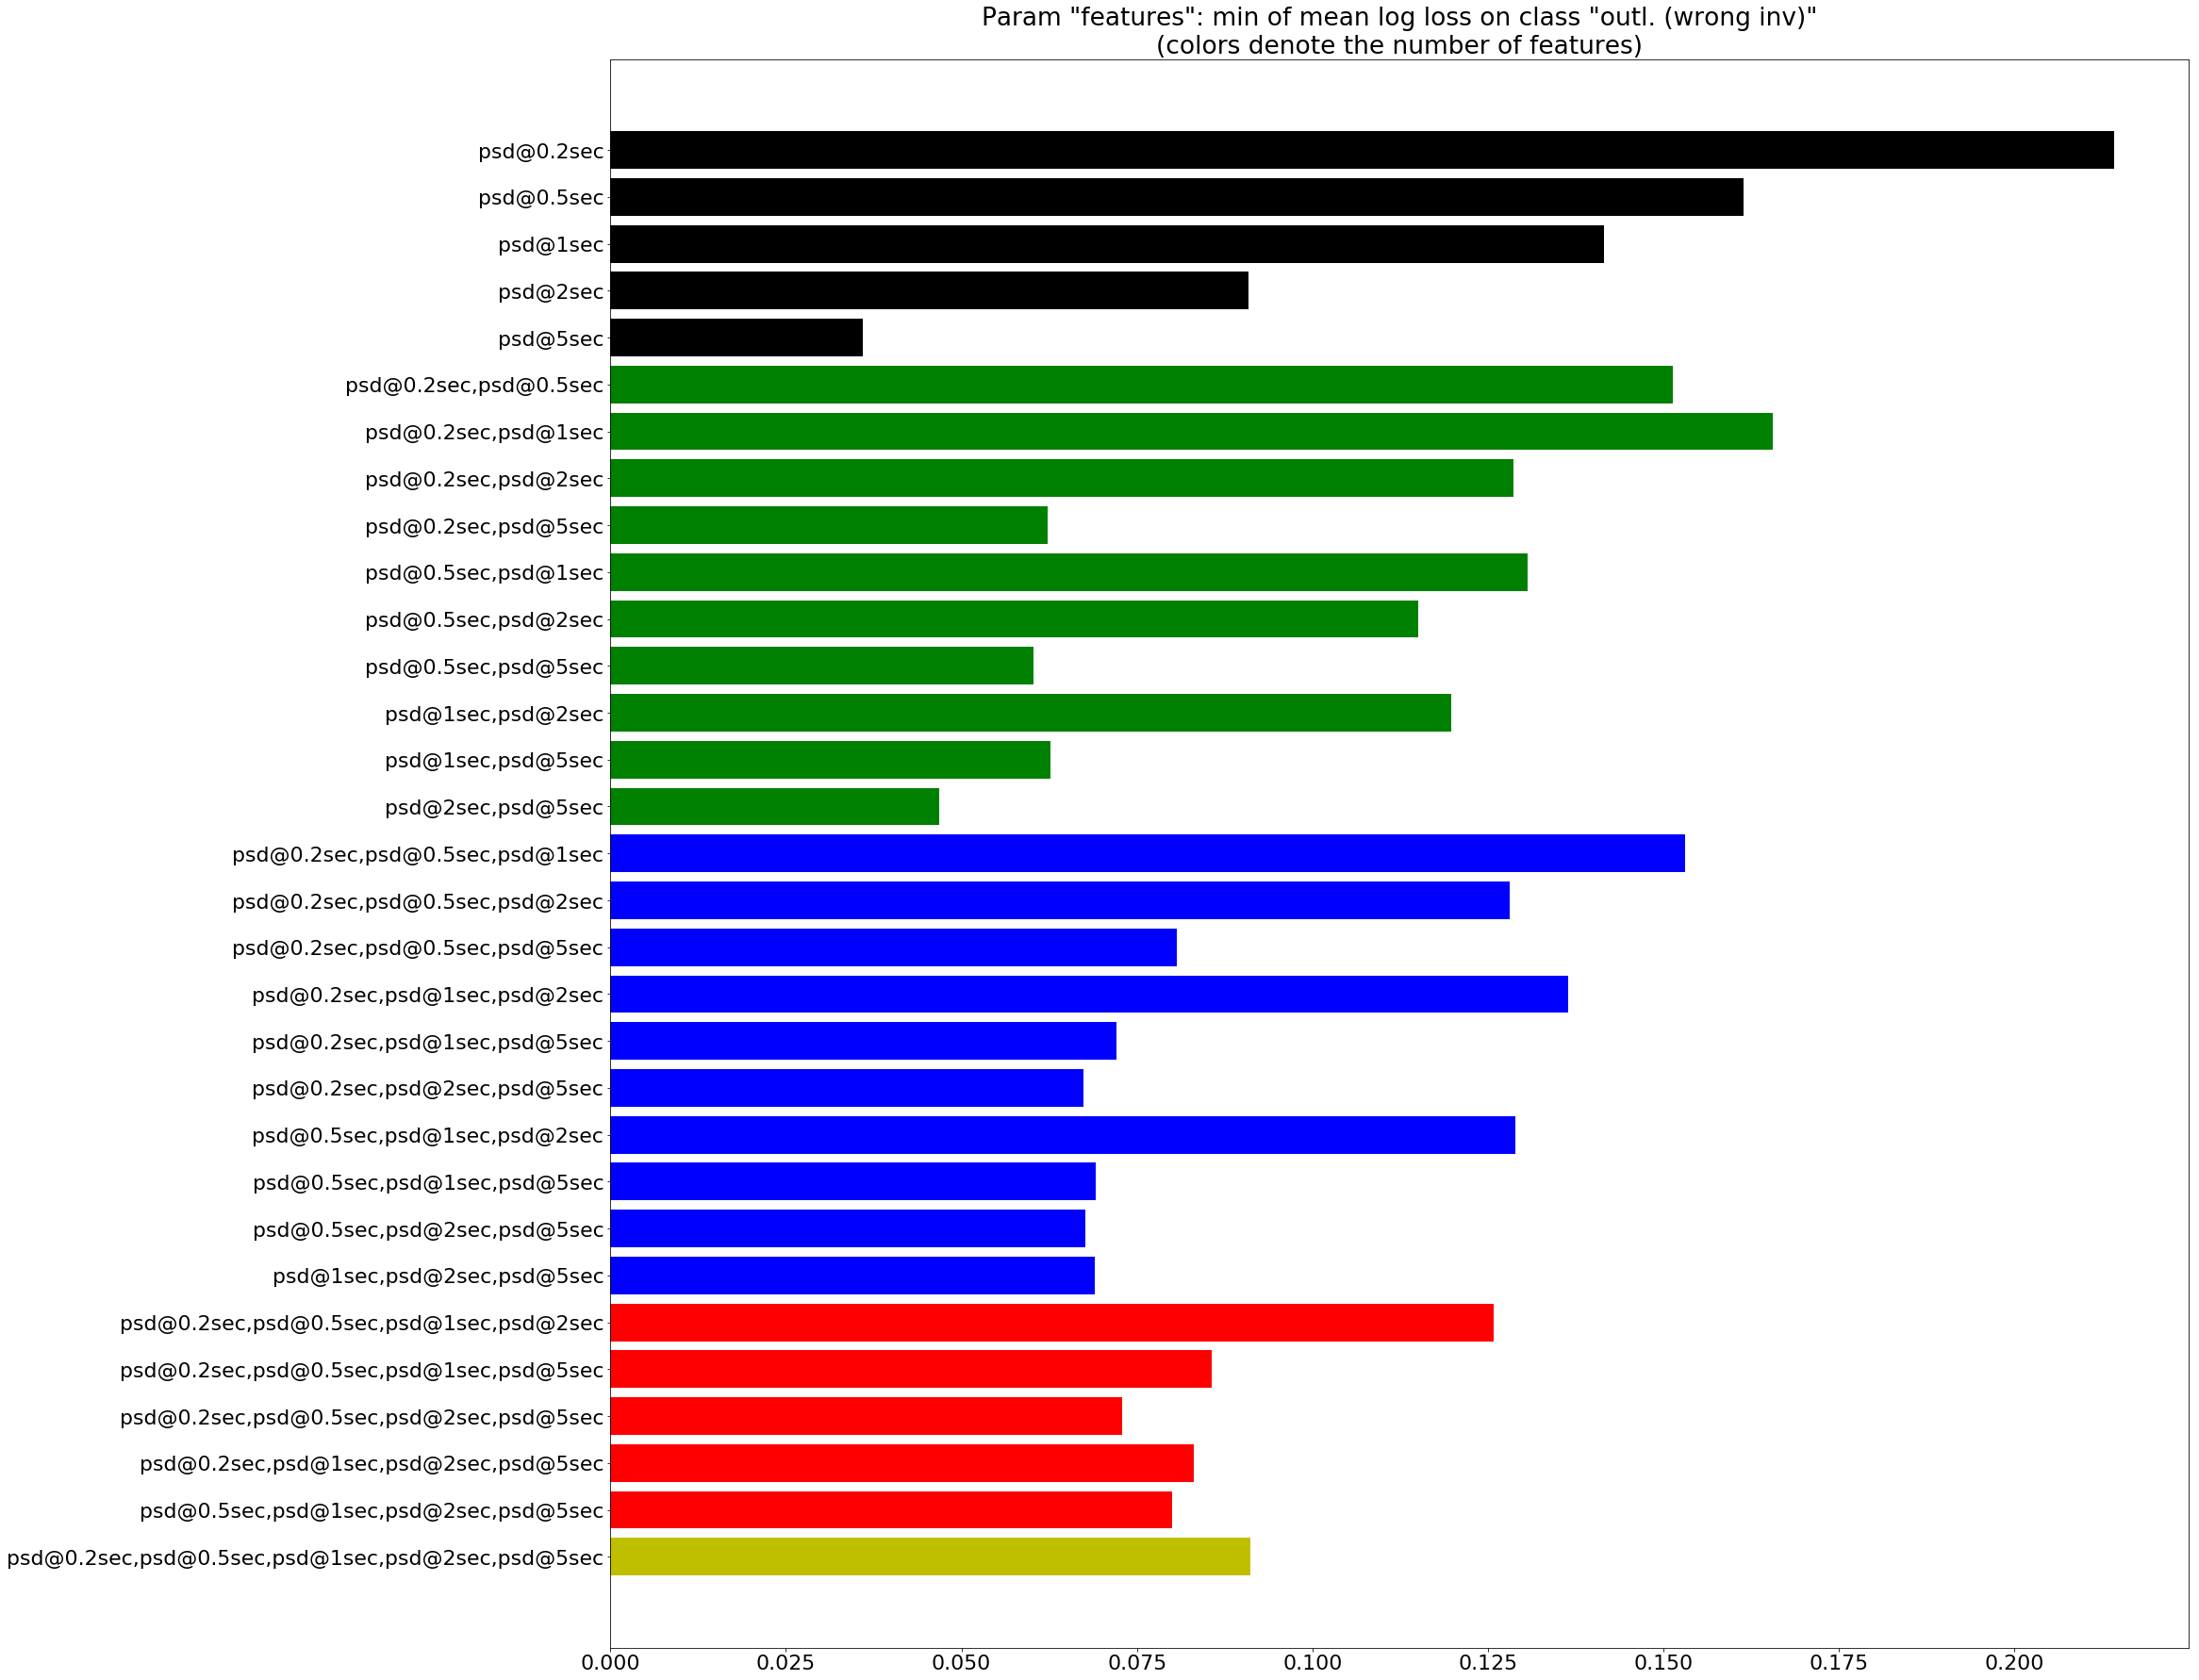

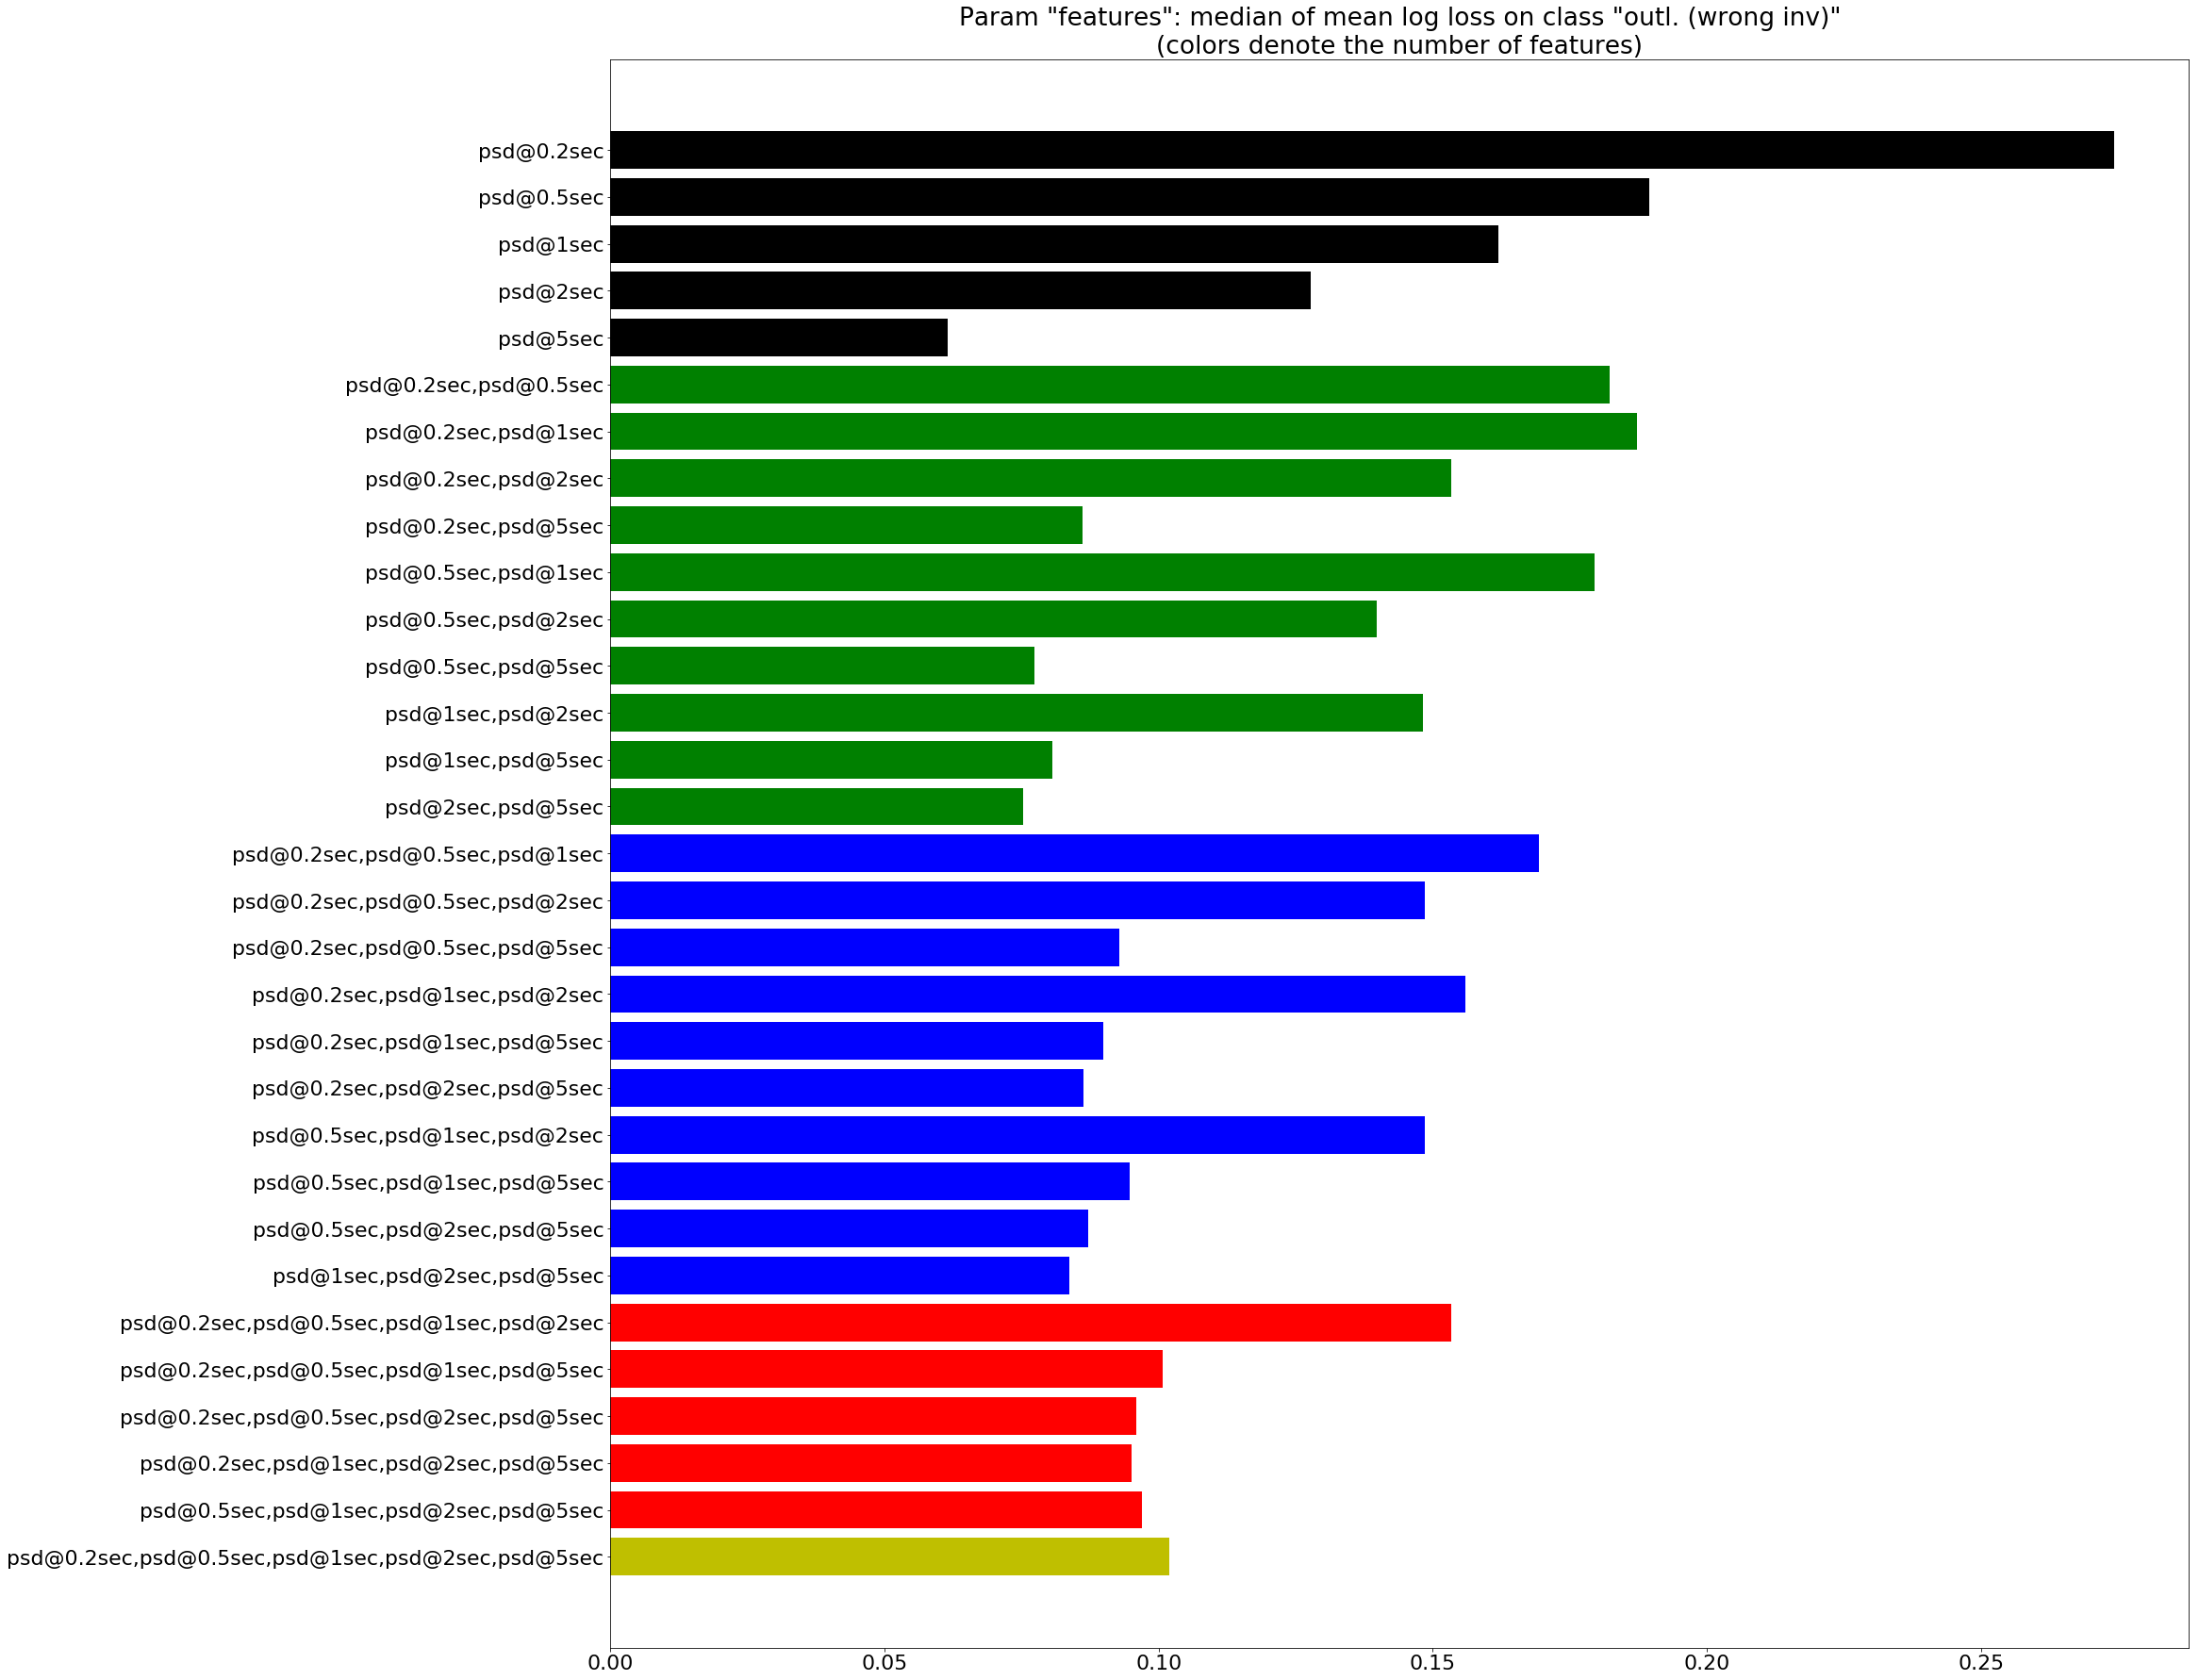

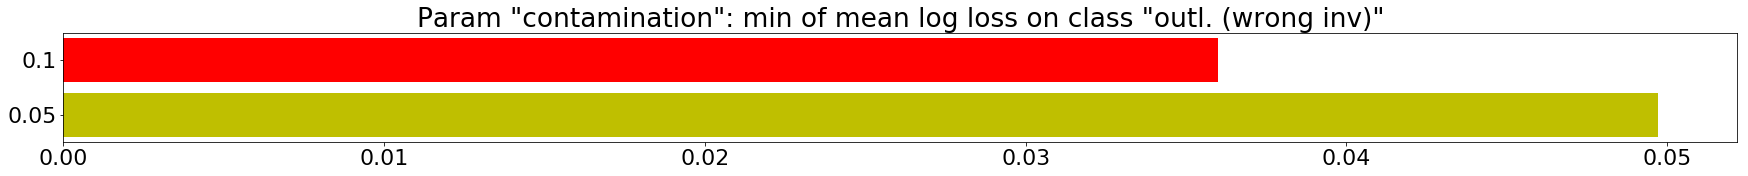

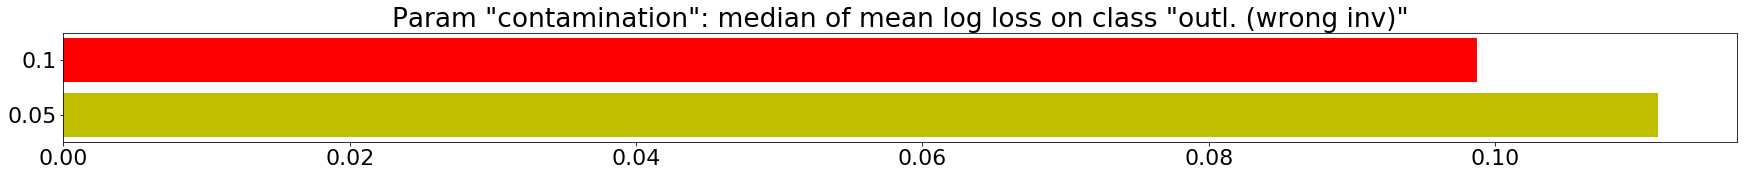

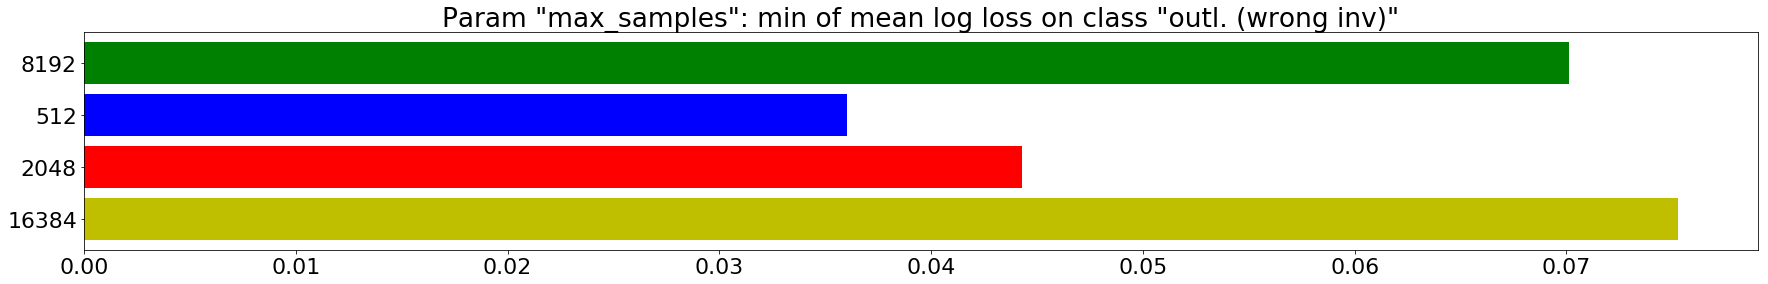

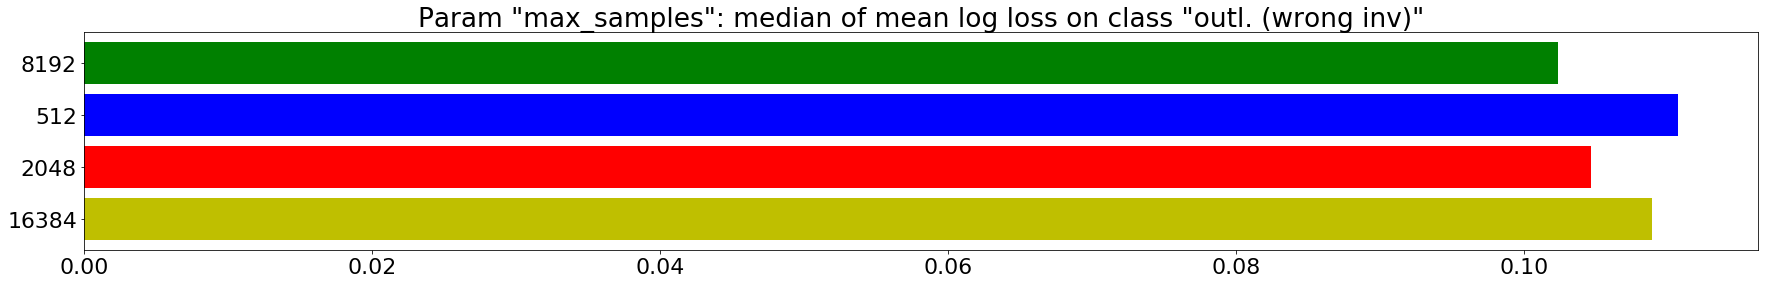

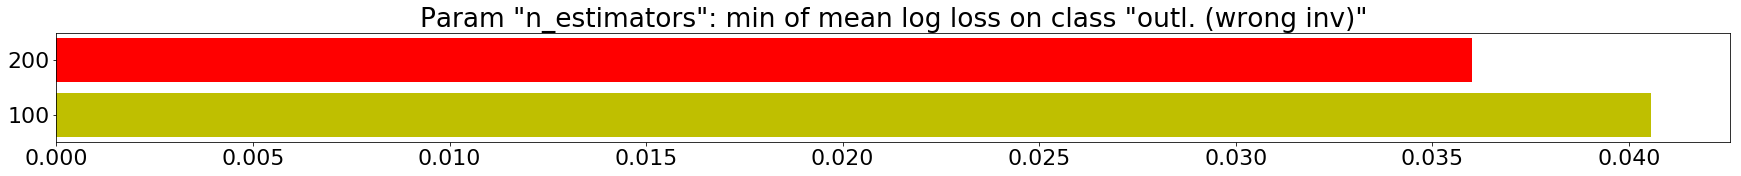

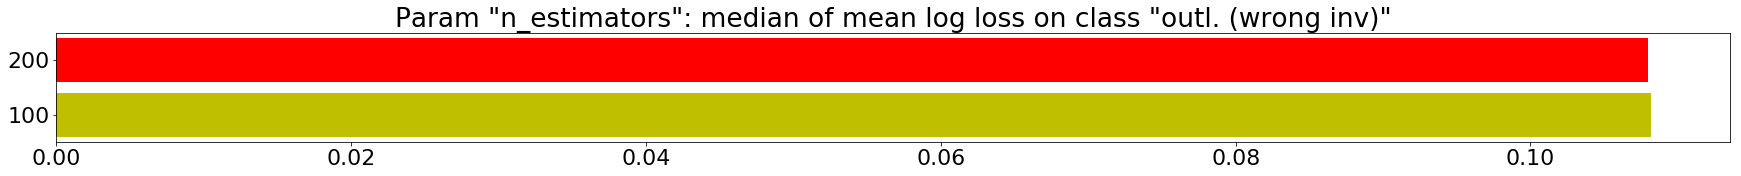

In [6]:
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict

%matplotlib inline

@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

tmp_fig_size = matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize']
# plt.rcParams.update({'font.size': 30})
# plt.rcParams.update({'figure.figsize': (22, 22)})


class_ = 'outl. (wrong inv)'

from itertools import cycle
basecolors = ['y', 'r', 'b', 'g', 'k']

columns = ['features', 'contamination', 'max_samples', 'n_estimators']



for col in columns:
        
    colors_ = iter(cycle(basecolors))
    colorsdict = defaultdict(lambda: next(colors_))

    # printing per feature with hbars (https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barh.html)
    numfeat2color = {1:'y', 2: 'r', 3: 'b', 4: 'g', 5: 'k'}

    data = defaultdict(list)
    for _, df_ in dfr.groupby(col):
        data[_].extend(_ for _ in df_[df_.classname == class_]['Mean log_loss'])

    if col == 'features':
        labels = sorted(data.keys(), key=lambda f: (len(f.split(',')), f), reverse=True)
        colors = [colorsdict[len(_.split(','))] for _ in labels]
        labelcap = '\n(colors denote the number of features)'
    else:
        labels = sorted((_ for _ in data), key=str)
        colors = [colorsdict[_] for _ in labels]
        labelcap = ''

    size = len(data)
    with plotparams({'figure.figsize': (30, size), 'font.size': 22}):

        avg = {_: np.nanmin(data[_]) for _ in data}
        # labels = sorted(avg.keys(), key=lambda f: (len(f.split(',')), f), reverse=True)
        # colors = [numfeat2color[len(_.split(','))] for _ in labels]
        # colors = [next(colors) for _ in labels]
        ypos = np.arange(len(labels))
        plt.barh(ypos, [avg[_] for _ in labels], align='center', color=colors)
        plt.title('Param "%s": min of mean log loss on class "%s"%s' % (col, class_, labelcap))
        plt.gca().set_yticks(ypos)
        # plt.gca().set_yticklabels((_.replace(",", ", ") for _ in labels))
        plt.gca().set_yticklabels(labels)

        # plt.xlabel('number of features')
        # plt.xticks(rotation=90)
        plt.show()

        avg = {_: np.quantile(data[_], 0.5) for _ in data}
        # labels = sorted(avg.keys(), key=lambda f: (len(f.split(',')), f), reverse=True)
        ypos = np.arange(len(labels))
        plt.barh(ypos, [avg[_] for _ in labels], align='center', color=colors)
        plt.title('Param "%s": median of mean log loss on class "%s"%s' % (col, class_, labelcap))
        plt.gca().set_yticks(ypos)
        # plt.gca().set_yticklabels((_.replace(",", ", ") for _ in labels))
        plt.gca().set_yticklabels(labels)

        # labels = sorted(avg.keys())
        # ypos = np.arange(len(labels))
        # plt.bar(avg.keys(), avg.values())
        # plt.title('Median of mean log loss on class "%s" ' % class_)
        # plt.xlabel('number of features')
        # plt.xticks(rotation=90)
        plt.show()
        
        print()

    # print(pd.Series(avg))

In [7]:
# TOMORROW: download 3 models, plot contour
# download the 3 models predictions, group by station, get median and calculate log_loss + correctly classified
# see number of correctly classified per number of segment, and if there is a relation

# OUTLOOK: test on other europe db segments?
# create some other artifacts and see how it works?


In [18]:
root = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations', 'results', 'cv.allset_train.iforest.yaml'))
assert(os.path.isdir(root))

# adding the two best with two features, with contamination 5% an 10%
fnames = {
    'psd[2,5] 0.1 512': 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.1&max_samples=512&n_estimators=100&behaviour=new',
    'psd[2,5] 0.05 2048': 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.05&max_samples=2048&n_estimators=100&behaviour=new',
    #'cont10%, samples2048': 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.1&max_samples=2048&n_estimators=200&behaviour=new',
    #'cont5%, samples512': 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.05&max_samples=512&n_estimators=200&behaviour=new',
}


clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}

for n, c in clfs.items():
    print('%s: %s' % (str(n), str(c)))

print('loading source trainset')
dataframe = sod_core_dataset.open_dataset('allset_train.hdf', normalize=False, verbose=False)

psd[2,5] 0.1 512: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=512, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd[2,5] 0.05 2048: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
loading source trainset



psd[2,5] 0.1 512: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=512, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)


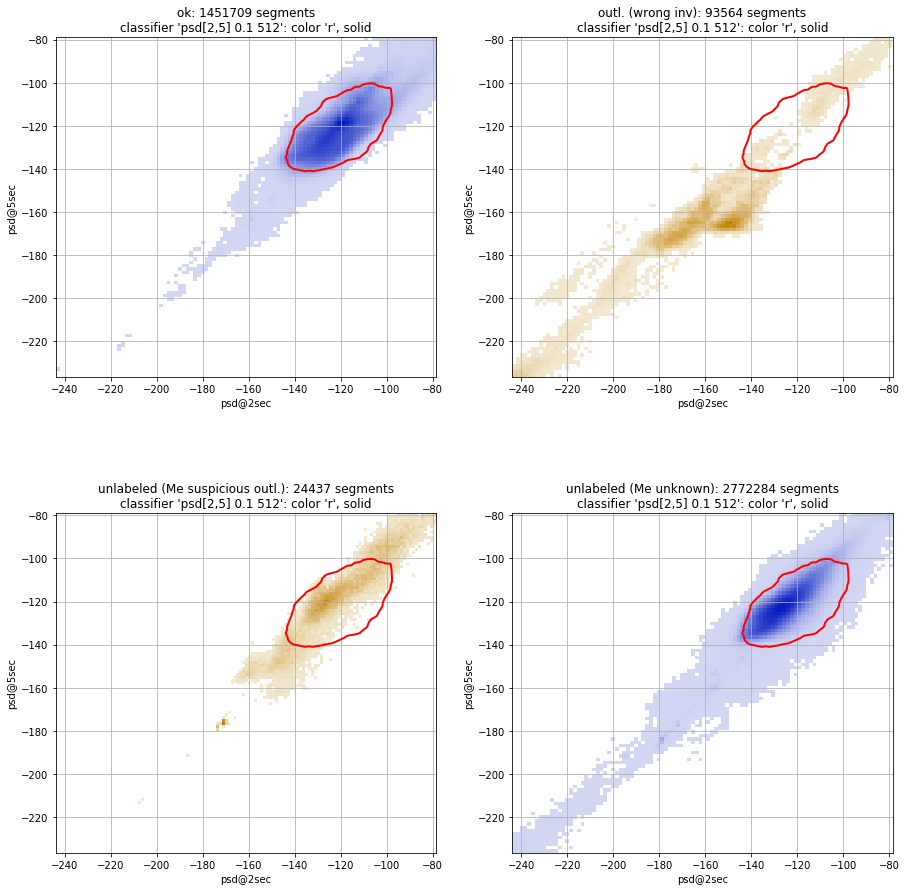


psd[2,5] 0.05 2048: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)


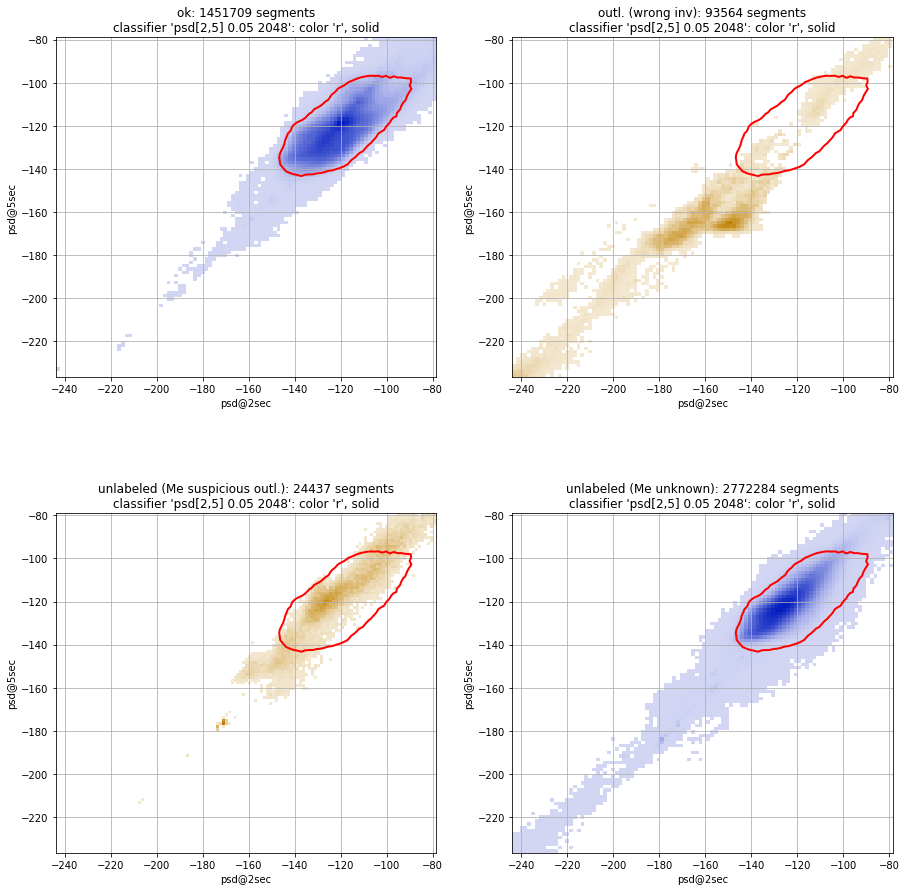

In [19]:
import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

feats = ['psd@2sec', 'psd@5sec']
%matplotlib inline
with plotparams({'figure.figsize': (15, 15)}):
    for clf_key, clf_val in clfs.items():
        print('\n%s: %s' % (str(clf_key), str(clf_val)))
        sod_plot.plot(dataframe, *feats, axis_lim=.9901, clfs={clf_key: clf_val})
        plt.show()

In [20]:
# adding now the two best overall:

fnames['psd[5] 0.1 512'] = 'IsolationForest?features=psd@5sec&contamination=0.1&max_samples=512&n_estimators=200&behaviour=new'
fnames['psd[5] 0.05 2048'] = 'IsolationForest?features=psd@5sec&contamination=0.05&max_samples=2048&n_estimators=100&behaviour=new'

clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}
for n, c in clfs.items():
    print('%s: %s' % (str(n), str(c)))

print('Opening predictions hdf files\n')
preds = {k: pd.read_hdf(os.path.join(root, 'predictions', v + '.hdf')) for k, v in fnames.items()}

for name, prd_df in preds.items():
    print('Decision function values of %s' % str(name))
    dinfo = sod_core_dataset.dataset_info(prd_df)
    print('inliers (min, median, max):')
    _prd_df = prd_df[dinfo.class_selector[dinfo.classnames[0]]]
    print((_prd_df.decision_function.min(), _prd_df.decision_function.median(), _prd_df.decision_function.max()))
    print('outliers (min, median, max):')
    _prd_df = prd_df[dinfo.class_selector[dinfo.classnames[1]]]
    print((_prd_df.decision_function.min(), _prd_df.decision_function.median(), _prd_df.decision_function.max()))
    print()


import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)
normalize = sod_core_eval.normalize

print('\nSetting categorical data')
colz = ['globalset.id', 'subclass', 'window_type', 'outlier']

for name, pred_df in preds.items():
    pred_df['channel_code'] = pred_df['channel_code'].astype('category')
    pred_df['location_code'] = pred_df['location_code'].astype('category')
    pred_df['cha_id'] = pred_df['channel_code'].str[:2]
    pred_df['cha_id'] = pred_df['cha_id'].astype('category')
    preds[name] = pred_df
    # print(pred2.columns)

print('\nDone. Predictions dataframes columns:')
print(list(preds.values())[0].columns.tolist())  # one is sufficient
print()

# FIXME: provare a normalizzare sui quantili

psd[2,5] 0.1 512: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=512, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd[2,5] 0.05 2048: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd[5] 0.1 512: IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples=512, n_estimators=200,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd[5] 0.05 2048: IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
Opening predictions hdf files

Decision function values of psd[2

In [22]:
import pandas as pd, numpy as np
import sod.core.evaluation as sod_core_eval
from collections import defaultdict

importlib.reload(sod_core_eval)
normalize = sod_core_eval.normalize

dinfo = sod_core_dataset.dataset_info(dataframe)
classnames = dinfo.classnames[:2] + dinfo.classnames[-2:]
# provide the action to be performed when missclassified. For the first two labels is 'wrong' (ground truth is reliable)
# for the second two is 'to check' (ground trutch is not reliable, it's Dino guess)
actions = ['wrong', 'wrong', 'to check', 'to check']

# OUTLIER MUST BE THE LAST COLUMN!
colz = ['cha_id', 'dataset_id', 'station_id', 'location_code', 'outlier']

print('Confusion matrices where each instance is a distinct channel (ignoring orientation code)')
print('The prediction is taken as the MEDIAN of the predictions for all channel\'s segments')
# print('Notes: CAI: classified as inlier, CAO: classified as outlier')
print('Notes: MQS: mean quality score in [0, 1]: 0=outlier to 1=inlier (good)')
print('')

wrong_stations = []
wrong_stations_to_clf = defaultdict(list)
clf2int = {name: i for i, name in enumerate(preds.keys(), 1)}

for name, pred_df in dict(preds).items():
    print()
    print(name)
    columns = ['ok', 'outl.', 'ok\'s MQS', 'outl.\'s MQS']
    data = defaultdict(list)
    index = []
    wrongs = []
    min_o, max_i = pred_df['decision_function'].min(), pred_df['decision_function'].max() 
    # max_o = -pred_df_o['decision_function'].min()
    # max_o, max_o = pred_df_i['decision_function'].min(), pred_df_i['decision_function'].max()
    for cname, action in zip(classnames, actions):
        csel = dinfo.class_selector[cname]
        dtmp = pred_df[csel(pred_df)]
        inlier, outlier = 0, 0 
        scores_i, scores_o = [], []  # inlier, outlier
        for (cha_id, d_id, s_id, loc_code, is_outlier), d in dtmp.groupby(colz):
            # val = d['quality'].median()
            val = np.nanmedian(normalize(d['decision_function'], [min_o, max_i], map_to=(0, 1)))
            # negatives are outliers
            write_df = False
            if val < 0.5:  # classified as outlier
                outlier += 1
                scores_o.append(val)
                if not is_outlier:
                    write_df = True
            elif val > 0.5:
                inlier += 1
                scores_i.append(val)
                if is_outlier:
                    write_df = True
            else:
                outlier += 0.5
                inlier += 0.5

            if write_df:
                wrong_stations_to_clf[(cha_id, d_id, s_id)].append(clf2int[name])
                clfnames = wrong_stations_to_clf[(cha_id, d_id, s_id)]
                wrong_stations.append({
                    'action': action,
                    'dataset_id': 'europe' if d_id == 1 else 'me' if d_id == 2 else 'CX',
                    'station_id': s_id,
                    'cha_id': cha_id,
                    'location_code': loc_code,
                    'expected quality': 0 if is_outlier else 1,
                    'quality': val,
                    'misclassified by*': ",".join(str(_) for _ in clfnames),
                    'num segs': len(d)
                })
        data[columns[0]].append(inlier)
        data[columns[1]].append(outlier)
        data[columns[2]].append(np.round(np.nanmean(scores_i), 3))
        data[columns[3]].append(np.round(np.nanmean(scores_o), 3))

    print(pd.DataFrame(index=classnames, data=data).to_string())

    
print('\nPrinting list of unique stations missclassified')
print('*misclassified by: an integer denoting a classifier:')
for key, val in clf2int.items():
    print('%d: %s' % (val, key))
print()

dflist = pd.DataFrame(wrong_stations)
dflist.drop_duplicates(subset=colz[:-1], inplace=True, keep='last')
dflist['loss'] = np.abs(dflist['expected quality'] - dflist['quality'])
dflist.sort_values(by=['action', 'loss', 'misclassified by*'], ascending=False, inplace=True)
dflist.drop(['loss'], axis=1, inplace=True)
dflist.reset_index(drop=True, inplace=True)
# re-order columns:
dflist = dflist[
                ['action',
                 'dataset_id',
                 'station_id',
                 'location_code',
                 'cha_id',
                 'expected quality',
                 'quality',
                 'misclassified by*',
                 'num segs']
               ]
print(dflist.to_string())

Confusion matrices where each instance is a distinct channel (ignoring orientation code)
The prediction is taken as the MEDIAN of the predictions for all channel's segments
Notes: MQS: mean quality score in [0, 1]: 0=outlier to 1=inlier (good)


psd[2,5] 0.1 512
                                   ok  outl.  ok's MQS  outl.'s MQS
ok                                636     17     0.814        0.320
outl. (wrong inv)                   1     56     0.765        0.055
unlabeled (Me suspicious outl.)    10      7     0.789        0.340
unlabeled (Me unknown)           2221    109     0.820        0.146

psd[2,5] 0.05 2048
                                   ok  outl.  ok's MQS  outl.'s MQS
ok                                642     11     0.847        0.316
outl. (wrong inv)                   1     56     0.841        0.124
unlabeled (Me suspicious outl.)    11      6     0.826        0.382
unlabeled (Me unknown)           2230    100     0.872        0.199

psd[5] 0.1 512
                     

ROC-like curve?

[1.94673096 0.94673096 0.80866961 0.80864549 0.77362824 0.77338898
 0.75637261 0.75575178 0.43059178 0.42469361 0.41716451 0.39249126
 0.21692799 0.21349688 0.20173443 0.19132644 0.18916526 0.18570011
 0.18549204 0.18369157 0.18364157 0.1825352  0.18171109 0.16671573
 0.16586696 0.16090879 0.16084927 0.15987173 0.14845187 0.1394977
 0.13835831 0.13756516 0.13677153 0.13518284 0.13488412 0.1319998
 0.11707762 0.11604656 0.10408483 0.08818258 0.08659716 0.08606818
 0.08553894 0.06794171 0.06767243 0.06686408 0.06605521 0.06551561
 0.06497576 0.06281374 0.0524415  0.04990686 0.04821459 0.04707058
 0.04652029 0.04291391 0.04126309 0.03631201 0.03545802 0.02987909
 0.02518162 0.02149577 0.00493956]


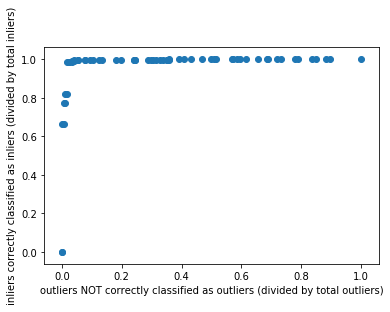

In [110]:
import pandas as pd, numpy as np
import sod.core.evaluation as sod_core_eval
from collections import defaultdict

importlib.reload(sod_core_eval)
normalize = sod_core_eval.normalize
from sklearn.metrics import roc_curve

dinfo = sod_core_dataset.dataset_info(dataframe)
classnames = dinfo.classnames[:2]

print('ROC-like curve?\n')

x = {_: 0 for _ in 0.1 * np.arange(1, 10)}
tot = 0

y_pred = []
y_true = []

for name, pred_df in dict(preds).items():
    columns = ['ok', 'outl.', 'ok\'s MQS', 'outl.\'s MQS']
    data = defaultdict(list)
    index = []
    wrongs = []
    min_o, max_i = pred_df['decision_function'].min(), pred_df['decision_function'].max() 
    # max_o = -pred_df_o['decision_function'].min()
    # max_o, max_o = pred_df_i['decision_function'].min(), pred_df_i['decision_function'].max()
    for cname in classnames:
        csel = dinfo.class_selector[cname]
        dtmp = pred_df[csel(pred_df)]
        inlier, outlier = 0, 0 
        scores_i, scores_o = [], []  # inlier, outlier
        for (cha_id, d_id, s_id, is_outlier), d in dtmp.groupby(colz):
            tot += 1
            # val = d['quality'].median()
            val = np.nanmedian(normalize(d['decision_function'], [min_o, max_i], map_to=(0, 1)))
            
            y_pred.append(val)
            y_true.append(-1 if is_outlier else 1)

            # negatives are outliers
#             for th in x.keys():
#                 if val >= th and not is_outlier:
#                     x[th] += 1
#                 elif val < th and is_outlier:
#                     x[th] += 1
# print(x)

# plt.bar(x.keys(), np.array(list(x.values())) / tot)
# plt.show()


fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plt.scatter(fpr, tpr)
plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
print(thresholds)